# Generative Adversarial Network

In this notebook, we'll be building a generative adversarial network (GAN) trained on the MNIST dataset. From this, we'll be able to generate new handwritten digits!

GANs were [first reported on](https://arxiv.org/abs/1406.2661) in 2014 from Ian Goodfellow and others in Yoshua Bengio's lab. Since then, GANs have exploded in popularity. Here are a few examples to check out:

* [Pix2Pix](https://affinelayer.com/pixsrv/) 
* [CycleGAN & Pix2Pix in PyTorch, Jun-Yan Zhu](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix)
* [A list of generative models](https://github.com/wiseodd/generative-models)

The idea behind GANs is that you have two networks, a generator $G$ and a discriminator $D$, competing against each other. The generator makes "fake" data to pass to the discriminator. The discriminator also sees real training data and predicts if the data it's received is real or fake. 
> * The generator is trained to fool the discriminator, it wants to output data that looks _as close as possible_ to real, training data. 
* The discriminator is a classifier that is trained to figure out which data is real and which is fake. 

What ends up happening is that the generator learns to make data that is indistinguishable from real data to the discriminator.

<img src='assets/gan_pipeline.png' width=70% />

The general structure of a GAN is shown in the diagram above, using MNIST images as data. The latent sample is a random vector that the generator uses to construct its fake images. This is often called a **latent vector** and that vector space is called **latent space**. As the generator trains, it figures out how to map latent vectors to recognizable images that can fool the discriminator.

If you're interested in generating only new images, you can throw out the discriminator after training. In this notebook, I'll show you how to define and train these adversarial networks in PyTorch and generate new images!generate new images!

In [95]:
%matplotlib inline

import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

In [52]:
from torchvision import datasets
import torchvision.transforms as T

# number of subproccesses to use for data loading
num_workers = 0 # all
# how many samples per batch to load
batch_size = 128

# Convert data to torch.FloatTensor()
transform = T.ToTensor()

# Get the training datasets
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)

# Prepare the dataloader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)

## Visualize the data

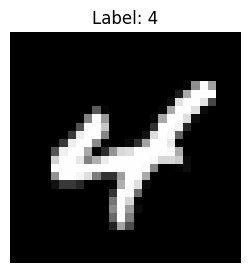

In [69]:
rand_index = np.random.randint(0, len(train_data), 1)[0]
image = train_data[rand_index][0]
label = train_data[rand_index][1]
image = image.numpy()
image = np.squeeze(image[0])

fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
ax.imshow(image, cmap='gray')
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()

In [16]:
images[0].shape

(28, 28)

---
## Define the Model
A GAN is comprised of two adversarial networks, a discriminator and a generator

## Discriminator

The discriminator network is going to be a pretty typical linear classifier. To make this network a universal function approximator, we'll need at least one hidden layer, and these hidden layers should have one key attribute:
> All hidden layers will have a [Leaky ReLu](https://pytorch.org/docs/stable/nn.html#torch.nn.LeakyReLU) activation function applied to their outputs.

<img src='assets/gan_network.png' width=70% />

#### Leaky ReLu

We should use a leaky ReLU to allow gradients to flow backwards through the layer unimpeded. A leaky ReLU is like a normal ReLU, except that there is a small non-zero output for negative input values.

<img src='assets/leaky_relu.png' width=40% />

#### Sigmoid Output

We'll also take the approach of using a more numerically stable loss function on the outputs. Recall that we want the discriminator to output a value 0-1 indicating whether an image is _real or fake_. 
> We will ultimately use [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss), which combines a `sigmoid` activation function **and** binary cross entropy loss in one function. 

So, our final output layer should not have any activation function applied to it.



In [143]:
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):
    """
    Discriminator Model:
    args:
    - input_dim : dimension of the input data. For a 28 * 28 grayscale image, the input size is 784
    - hidden_dim: a parameter that controls the dimension of the hidden layers.
    """

    def __init__(self, input_size: int, hidden_dim: int):
        super(Discriminator, self).__init__()

        # Define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, hidden_dim // 4)

        # Final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim // 4, 1)

        # Dropout layer
        self.dropout = nn.Dropout(0.3)

        # Define the activation
        self.activation = nn.LeakyReLU(0.2)

        # Flattem layer
        self.flatten = nn.Flatten()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Flatten image
        x = self.flatten(x)

        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.activation(x)
        x = self.dropout(x)
        
        x = self.fc3(x)
        x = self.activation(x)
        x = self.dropout(x)

        # BCE with logits loss will be applied
        x = self.fc4(x)
        return x

## Generator

The generator network will be almost exactly the same as the discriminator network, except that we're applying a [tanh activation function](https://pytorch.org/docs/stable/nn.html#tanh) to our output layer.

#### tanh Output
The generator has been found to perform the best with $tanh$ for the generator output, which scales the output to be between -1 and 1, instead of 0 and 1. 

<img src='assets/tanh_fn.png' width=40% />

Recall that we also want these outputs to be comparable to the *real* input pixel values, which are read in as normalized values between 0 and 1. 
> So, we'll also have to **scale our real input images to have pixel values between -1 and 1** when we train the discriminator. 

I'll do this in the training loop, later on.

In [144]:
class Generator(nn.Module):

    def __init__(self, latent_dim: int, hidden_dim: int, output_size: int):
        super(Generator, self).__init__()

        # Define hidden linear layers
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.fc3 = nn.Linear(hidden_dim * 2, hidden_dim * 4)

        # Final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim * 4, output_size)

        # Define the activation
        self.activation = nn.LeakyReLU(0.2)
        self.final_activation = nn.Tanh()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = self.activation(x)
        
        x = self.fc2(x)
        x = self.activation(x)
        
        x = self.fc3(x)
        x = self.activation(x)

        x = self.fc4(x)
        x = self.final_activation(x)
        return x

### Model Hyper parameters

In [145]:
# Size of input image to discriminator (28*28)
input_dim = 784
# Size of hidden layer
hidden_size = 256
# Size of latent vector to give to generator
latent_dim = 128
# Size of generator output (generated image)
output_dim = 784

## Build complete network

Now we're instantiating the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [146]:
D = Discriminator(input_dim, hidden_size)
G = Generator(latent_dim, hidden_size, output_dim)

# Check the architecture
print(D)
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (activation): LeakyReLU(negative_slope=0.2)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)
Generator(
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
  (activation): LeakyReLU(negative_slope=0.2)
  (final_activation): Tanh()
)


---
## Discriminator and Generator Losses

Now we need to calculate the losses. 

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.

<img src='assets/gan_pipeline.png' width=70% />

The losses will by binary cross entropy loss with logits, which we can get with [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss). This combines a `sigmoid` activation function **and** and binary cross entropy loss in one function.

For the real images, we want `D(real_images) = 1`. That is, we want the discriminator to classify the the real images with a label = 1, indicating that these are real. To help the discriminator generalize better, the labels are **reduced a bit from 1.0 to 0.9**. For this, we'll use the parameter `smooth`; if True, then we should smooth our labels. In PyTorch, this looks like `labels = torch.ones(size) * 0.9`

The discriminator loss for the fake data is similar. We want `D(fake_images) = 0`, where the fake images are the _generator output_, `fake_images = G(z)`. 


In [147]:
# Calculate losses
def real_loss(D_out, smooth=False):
    # Label smoothing
    if smooth:
        # Smooth, real labels = 0.9
        labels = torch.ones_like(D_out) * 0.9
    else: 
        labels = torch.ones_like(D_out) # real labels = 1
    # numerically stable loss
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out, labels)
    return loss


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get `D(fake_images) = 1`. In this case, the labels are **flipped** to represent that the generator is trying to fool the discriminator into thinking that the images it generates (fakes) are real!

In [148]:
def fake_loss(D_out):
    labels = torch.zeros_like(D_out) # Fake labels = 0
    criterion = nn.BCEWithLogitsLoss()
    # Calculate loss
    loss = criterion(D_out, labels)
    return loss

## Optimizers

We want to update the generator and discriminator variables separately. So, we'll define two separate Adam optimizers.

In [149]:
import torch.optim as optim

# Hyperparameter
lr = 2e-4

d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

---
## Training

Training will involve alternating between training the discriminator and the generator. We'll use our functions `real_loss` and `fake_loss` to help us calculate the discriminator losses in all of the following cases.

### Discriminator training
1. Compute the discriminator loss on real, training images        
2. Generate fake images
3. Compute the discriminator loss on fake, generated images     
4. Add up real and fake loss
5. Perform backpropagation + an optimization step to update the discriminator's weights

### Generator training
1. Generate fake images
2. Compute the discriminator loss on fake images, using **flipped** labels!
3. Perform backpropagation + an optimization step to update the generator's weights

#### Saving Samples

As we train, we'll also print out some loss statistics and save some generated "fake" samples.

In [150]:
from datetime import datetime
import pickle as pkl

In [151]:
# Helper function for viewing a list of passed in sample images 
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(14, 4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    plt.show()

Epoch 1/10:   0%|                                                                                                                                                                                       | 0/469 [00:00<?, ?it/s]

2024-03-29 03:12:09 | Epoch [1/10] | Batch 0/469 | d_loss: 1.0651 | g_loss: 1.6827


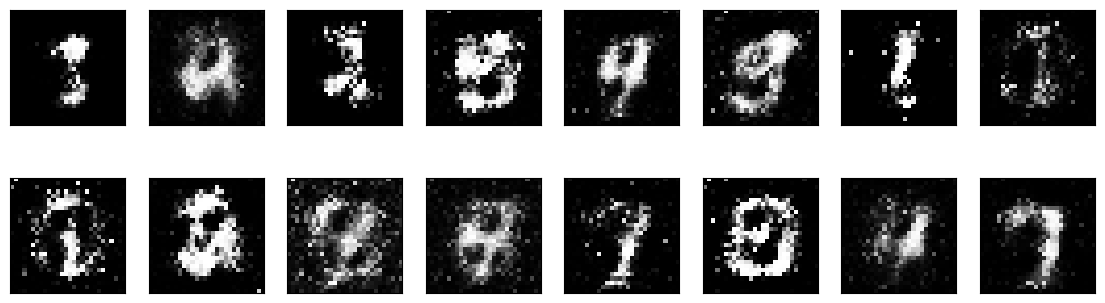

Epoch 1/10:  21%|████████████████████████████████████▋                                                                                                                                         | 99/469 [00:08<00:26, 14.02it/s]

2024-03-29 03:12:17 | Epoch [1/10] | Batch 100/469 | d_loss: 1.2236 | g_loss: 1.1738


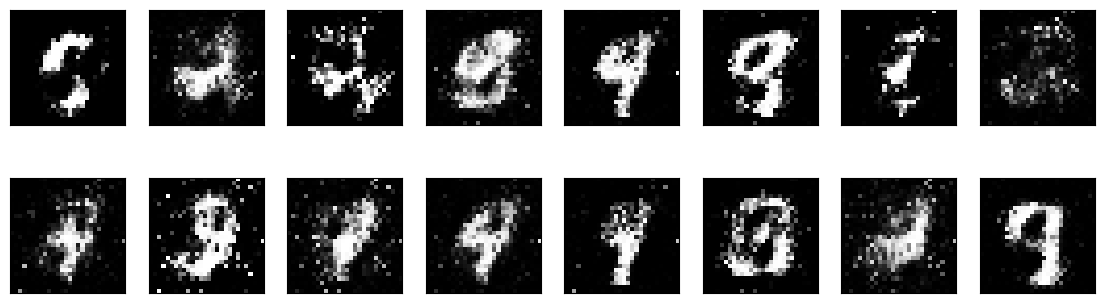

Epoch 1/10:  42%|█████████████████████████████████████████████████████████████████████████▍                                                                                                   | 199/469 [00:16<00:21, 12.57it/s]

2024-03-29 03:12:26 | Epoch [1/10] | Batch 200/469 | d_loss: 1.1958 | g_loss: 1.2991


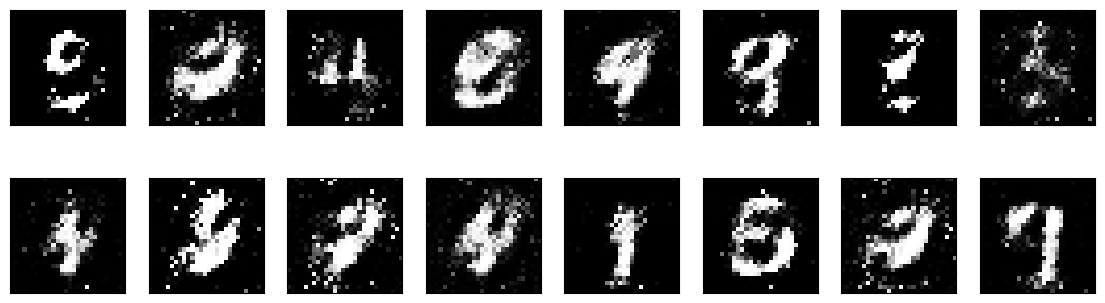

Epoch 1/10:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 299/469 [00:25<00:13, 12.69it/s]

2024-03-29 03:12:35 | Epoch [1/10] | Batch 300/469 | d_loss: 1.0810 | g_loss: 1.3673


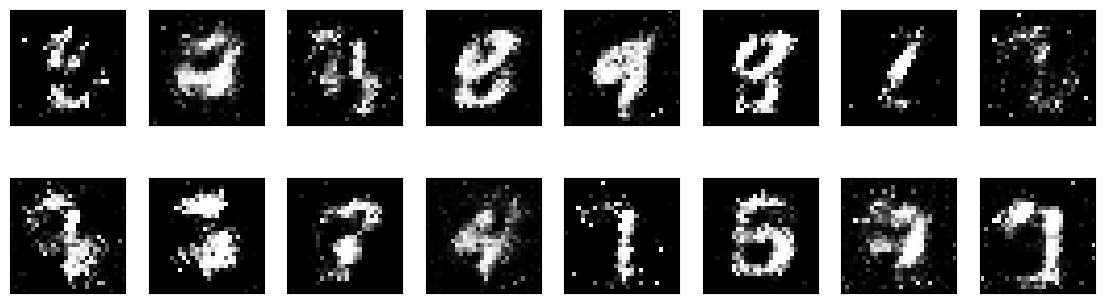

Epoch 1/10:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 399/469 [00:34<00:05, 12.47it/s]

2024-03-29 03:12:44 | Epoch [1/10] | Batch 400/469 | d_loss: 0.9823 | g_loss: 1.6325


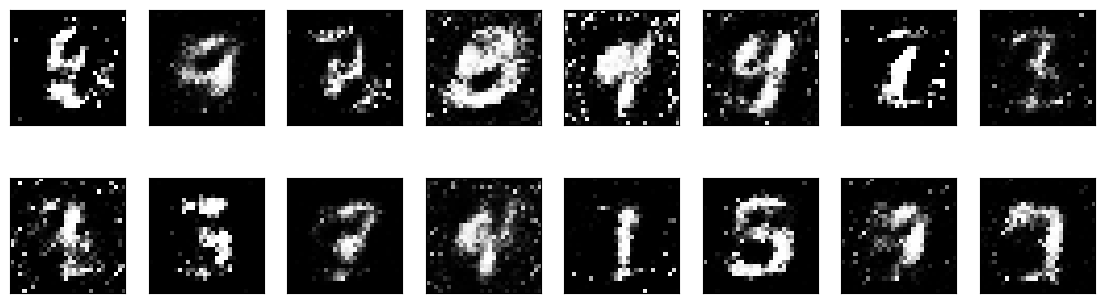

Epoch 2/10:   0%|                                                                                                                                                                                       | 0/469 [00:00<?, ?it/s]

2024-03-29 03:12:50 | Epoch [2/10] | Batch 0/469 | d_loss: 1.1857 | g_loss: 1.3157


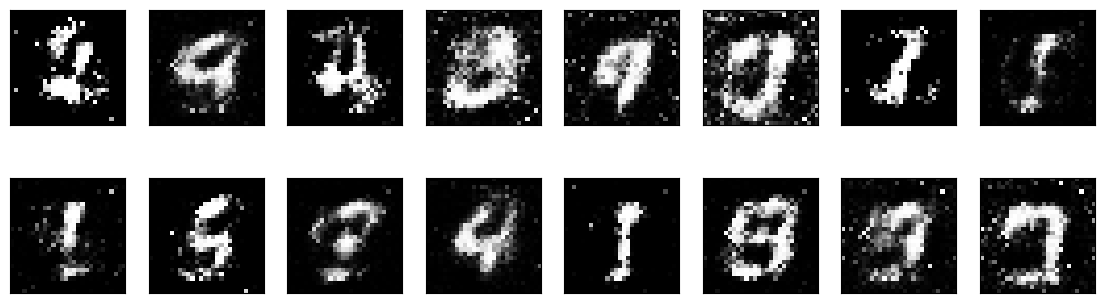

Epoch 2/10:  21%|████████████████████████████████████▋                                                                                                                                         | 99/469 [00:08<00:28, 13.02it/s]

2024-03-29 03:12:58 | Epoch [2/10] | Batch 100/469 | d_loss: 1.1061 | g_loss: 1.3061


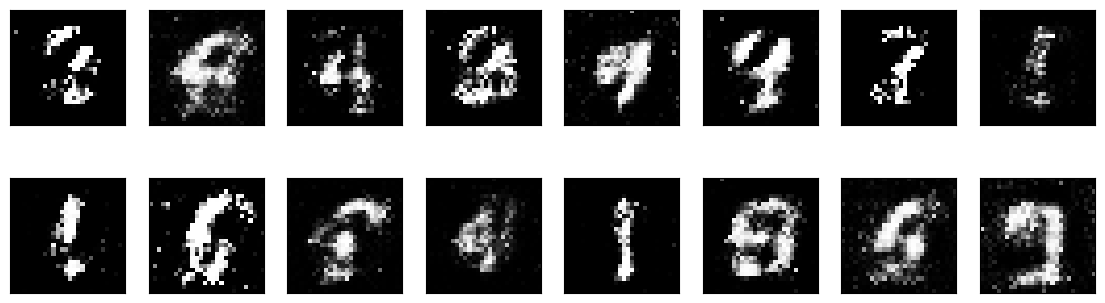

Epoch 2/10:  42%|█████████████████████████████████████████████████████████████████████████▍                                                                                                   | 199/469 [00:16<00:20, 13.48it/s]

2024-03-29 03:13:06 | Epoch [2/10] | Batch 200/469 | d_loss: 1.0753 | g_loss: 1.3888


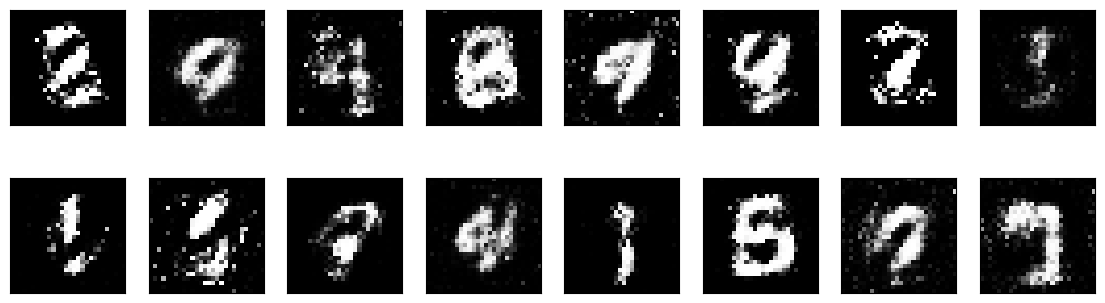

Epoch 2/10:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 299/469 [00:24<00:12, 13.56it/s]

2024-03-29 03:13:14 | Epoch [2/10] | Batch 300/469 | d_loss: 0.9865 | g_loss: 1.6076


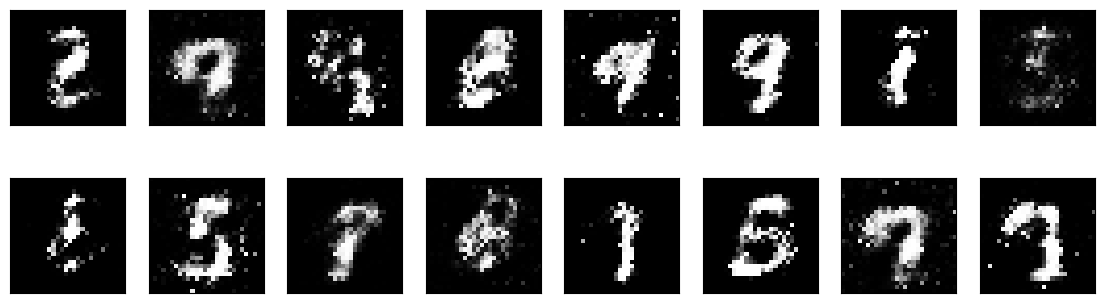

Epoch 2/10:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 399/469 [00:32<00:04, 14.18it/s]

2024-03-29 03:13:22 | Epoch [2/10] | Batch 400/469 | d_loss: 1.0825 | g_loss: 1.5109


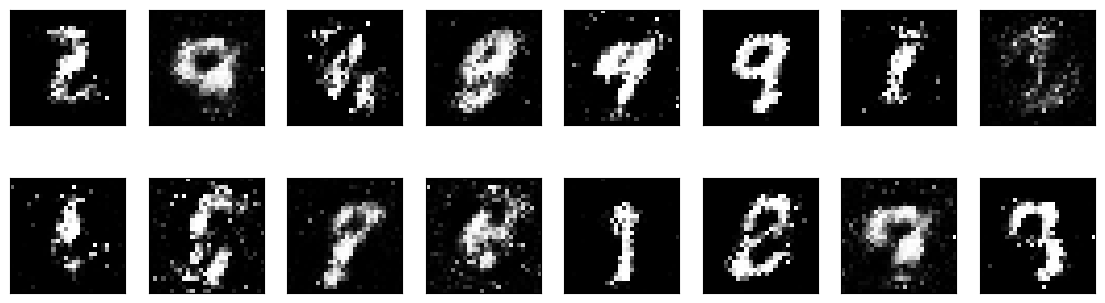

Epoch 3/10:   0%|                                                                                                                                                                                       | 0/469 [00:00<?, ?it/s]

2024-03-29 03:13:28 | Epoch [3/10] | Batch 0/469 | d_loss: 1.0073 | g_loss: 1.7582


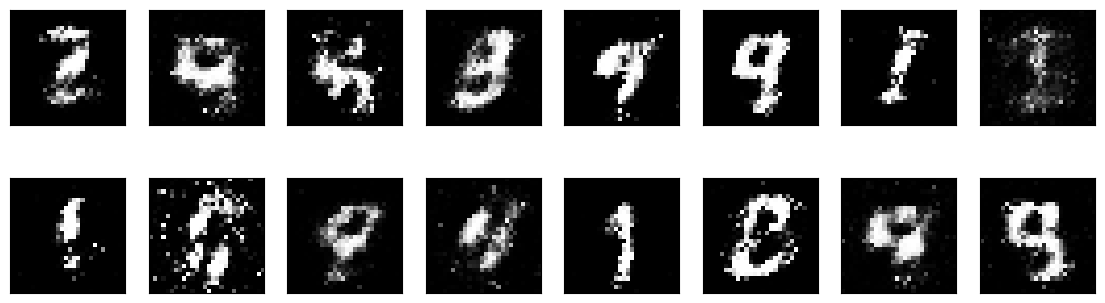

Epoch 3/10:  21%|████████████████████████████████████▋                                                                                                                                         | 99/469 [00:07<00:26, 13.73it/s]

2024-03-29 03:13:36 | Epoch [3/10] | Batch 100/469 | d_loss: 1.1546 | g_loss: 1.2525


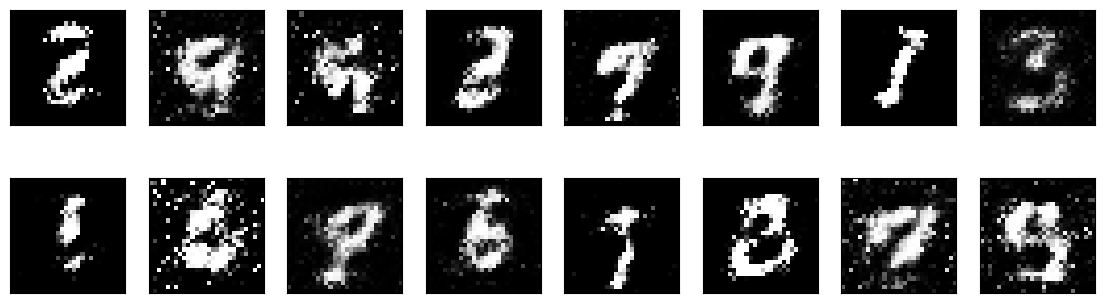

Epoch 3/10:  42%|█████████████████████████████████████████████████████████████████████████▍                                                                                                   | 199/469 [00:15<00:19, 14.09it/s]

2024-03-29 03:13:44 | Epoch [3/10] | Batch 200/469 | d_loss: 0.9894 | g_loss: 1.4906


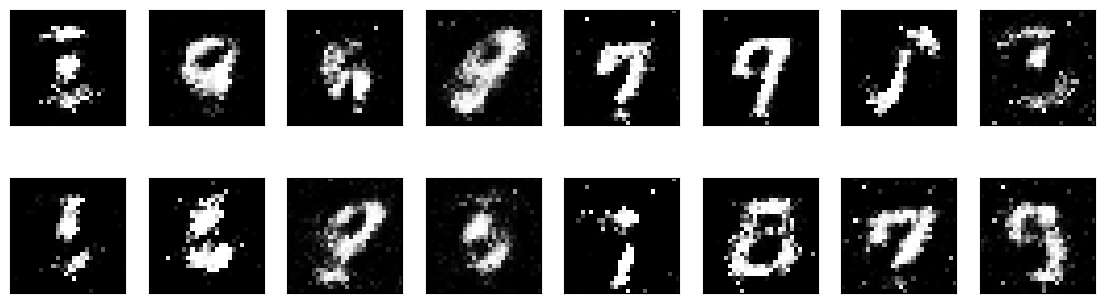

Epoch 3/10:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 299/469 [00:23<00:12, 13.74it/s]

2024-03-29 03:13:52 | Epoch [3/10] | Batch 300/469 | d_loss: 1.0732 | g_loss: 1.4564


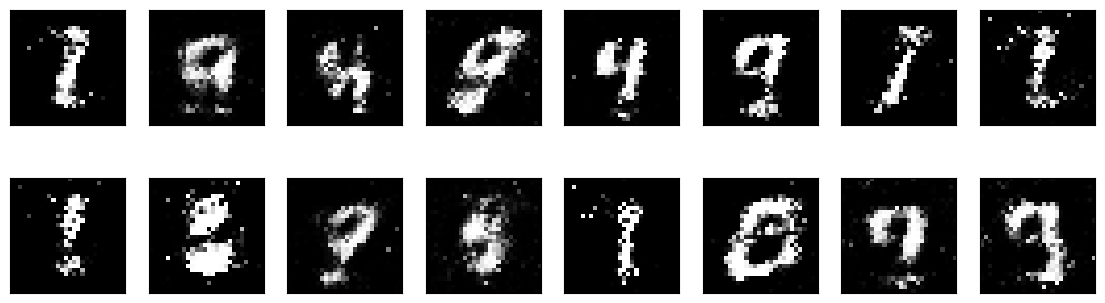

Epoch 3/10:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 399/469 [00:32<00:05, 13.72it/s]

2024-03-29 03:14:00 | Epoch [3/10] | Batch 400/469 | d_loss: 1.2301 | g_loss: 1.1464


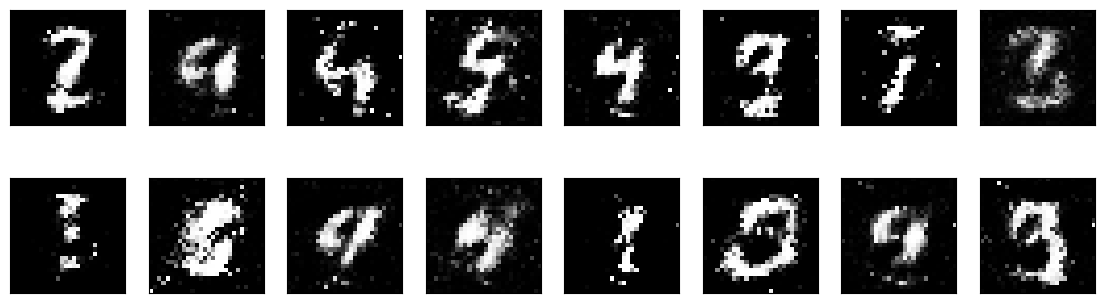

Epoch 4/10:   0%|                                                                                                                                                                                       | 0/469 [00:00<?, ?it/s]

2024-03-29 03:14:06 | Epoch [4/10] | Batch 0/469 | d_loss: 1.1980 | g_loss: 1.4024


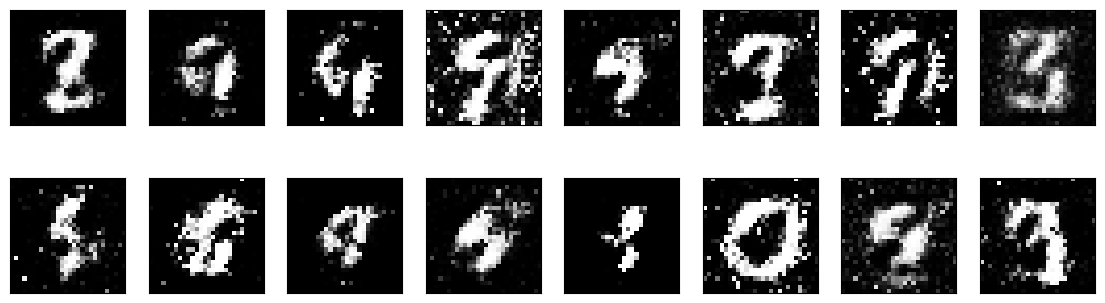

Epoch 4/10:  21%|████████████████████████████████████▋                                                                                                                                         | 99/469 [00:07<00:26, 14.02it/s]

2024-03-29 03:14:14 | Epoch [4/10] | Batch 100/469 | d_loss: 0.9287 | g_loss: 1.6978


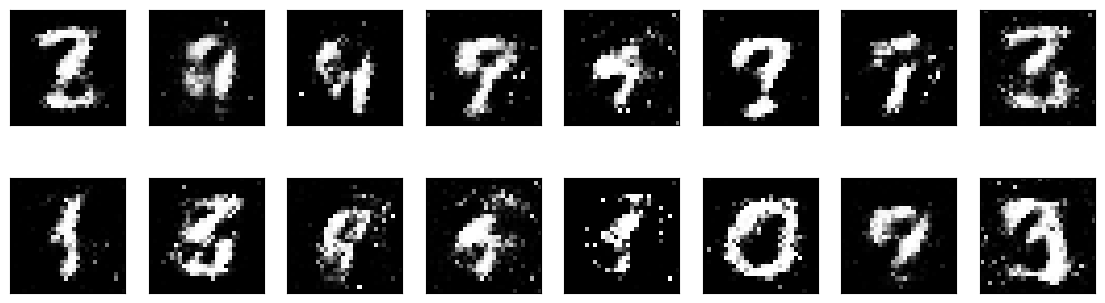

Epoch 4/10:  42%|█████████████████████████████████████████████████████████████████████████▍                                                                                                   | 199/469 [00:15<00:19, 13.88it/s]

2024-03-29 03:14:22 | Epoch [4/10] | Batch 200/469 | d_loss: 1.2444 | g_loss: 1.2218


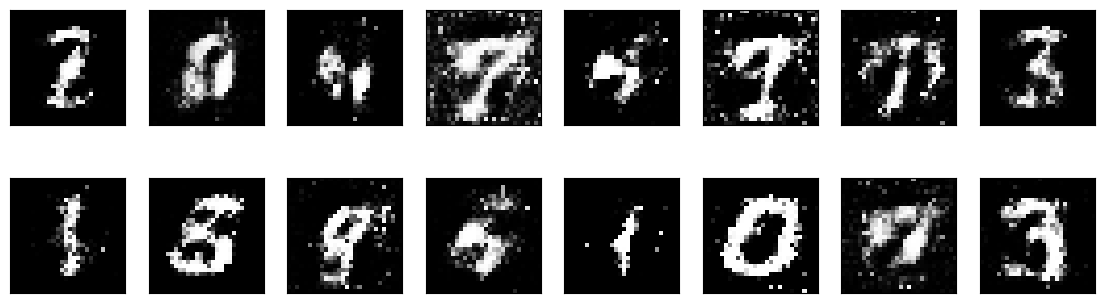

Epoch 4/10:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 299/469 [00:23<00:12, 13.87it/s]

2024-03-29 03:14:30 | Epoch [4/10] | Batch 300/469 | d_loss: 1.1646 | g_loss: 1.1829


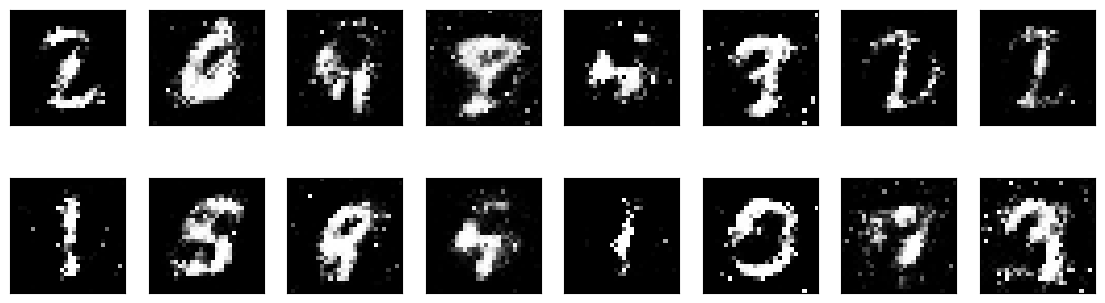

Epoch 4/10:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 399/469 [00:31<00:05, 13.96it/s]

2024-03-29 03:14:38 | Epoch [4/10] | Batch 400/469 | d_loss: 1.1780 | g_loss: 1.3312


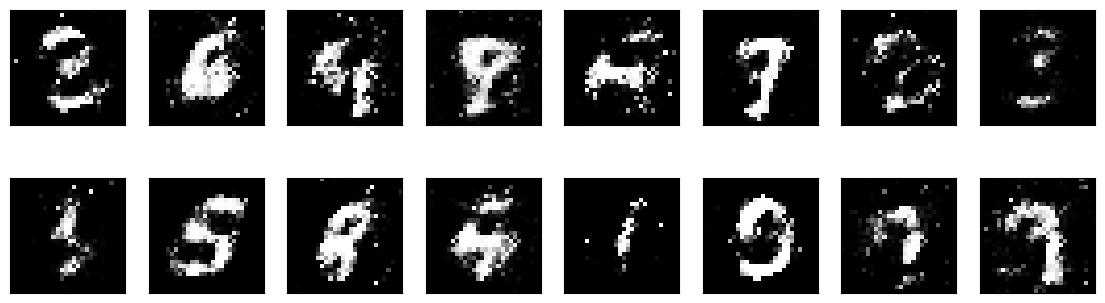

Epoch 5/10:   0%|                                                                                                                                                                                       | 0/469 [00:00<?, ?it/s]

2024-03-29 03:14:43 | Epoch [5/10] | Batch 0/469 | d_loss: 1.2397 | g_loss: 1.2466


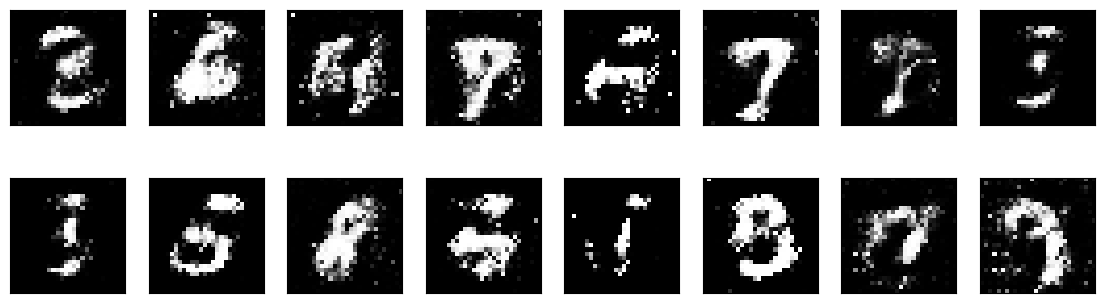

Epoch 5/10:  21%|████████████████████████████████████▋                                                                                                                                         | 99/469 [00:07<00:27, 13.59it/s]

2024-03-29 03:14:51 | Epoch [5/10] | Batch 100/469 | d_loss: 0.9995 | g_loss: 1.7306


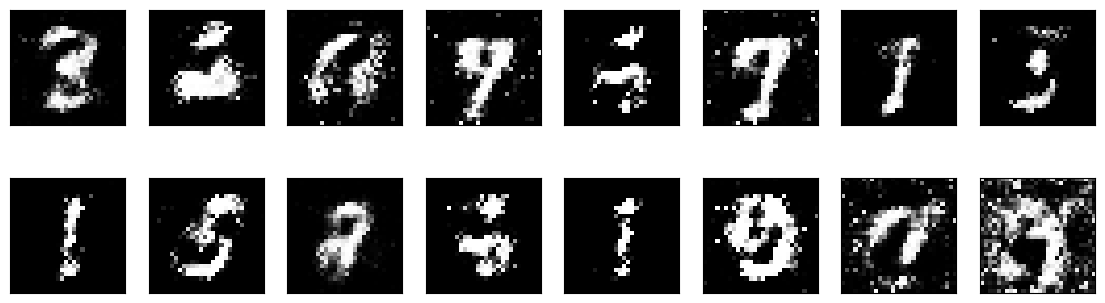

Epoch 5/10:  42%|█████████████████████████████████████████████████████████████████████████▍                                                                                                   | 199/469 [00:15<00:19, 14.01it/s]

2024-03-29 03:14:59 | Epoch [5/10] | Batch 200/469 | d_loss: 1.2059 | g_loss: 1.4630


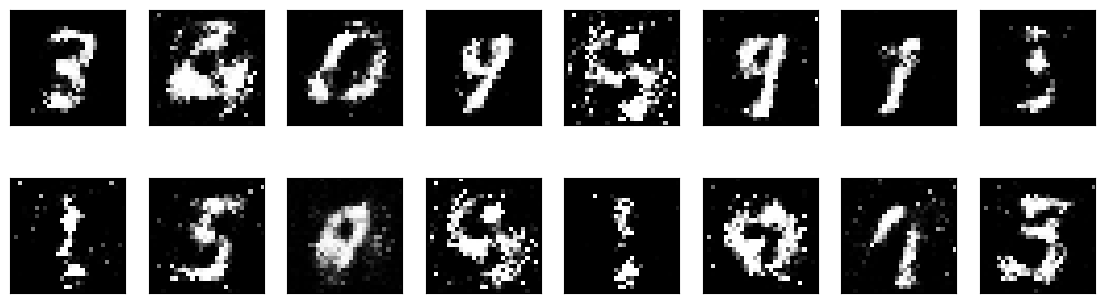

Epoch 5/10:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 299/469 [00:23<00:11, 14.34it/s]

2024-03-29 03:15:07 | Epoch [5/10] | Batch 300/469 | d_loss: 1.1653 | g_loss: 1.2515


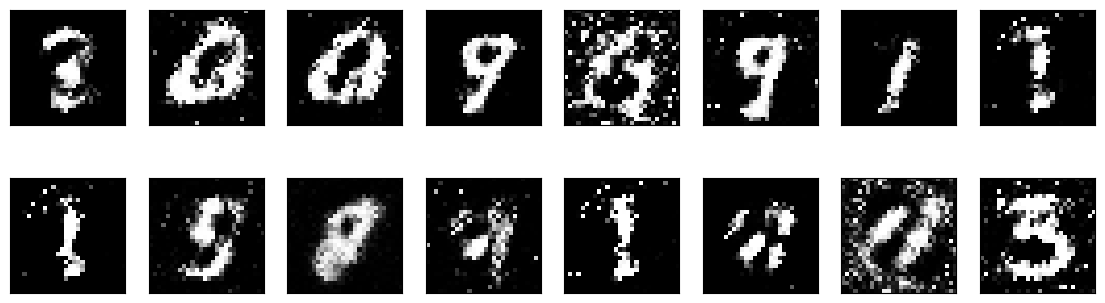

Epoch 5/10:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 399/469 [00:31<00:04, 14.15it/s]

2024-03-29 03:15:15 | Epoch [5/10] | Batch 400/469 | d_loss: 1.1283 | g_loss: 1.1376


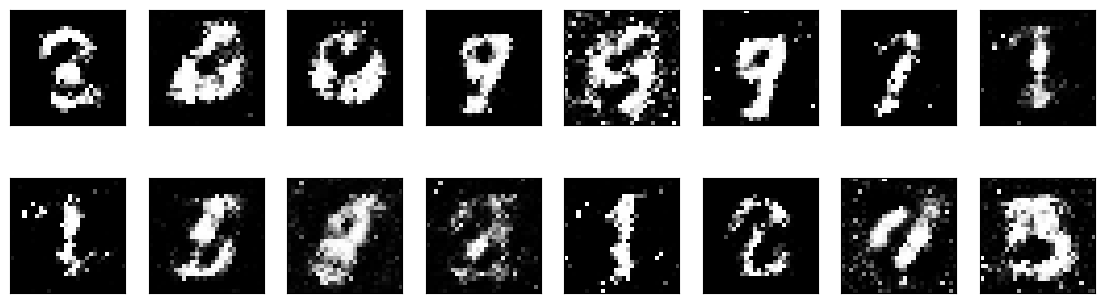

Epoch 6/10:   0%|                                                                                                                                                                                       | 0/469 [00:00<?, ?it/s]

2024-03-29 03:15:22 | Epoch [6/10] | Batch 0/469 | d_loss: 1.1834 | g_loss: 1.2248


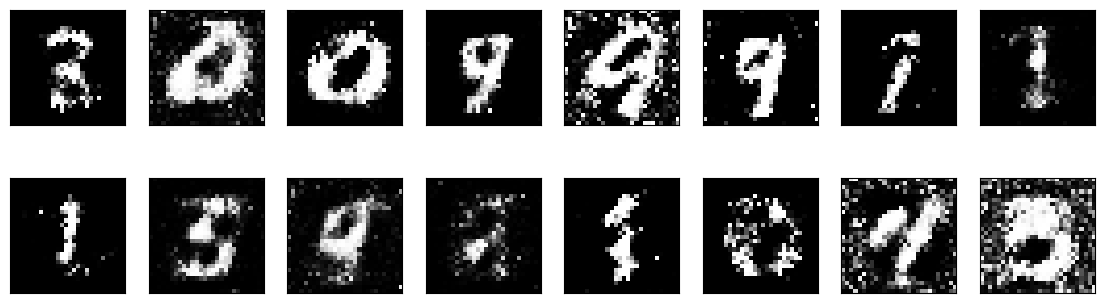

Epoch 6/10:  21%|████████████████████████████████████▉                                                                                                                                        | 100/469 [00:08<00:28, 12.91it/s]

2024-03-29 03:15:31 | Epoch [6/10] | Batch 100/469 | d_loss: 1.1300 | g_loss: 1.2972


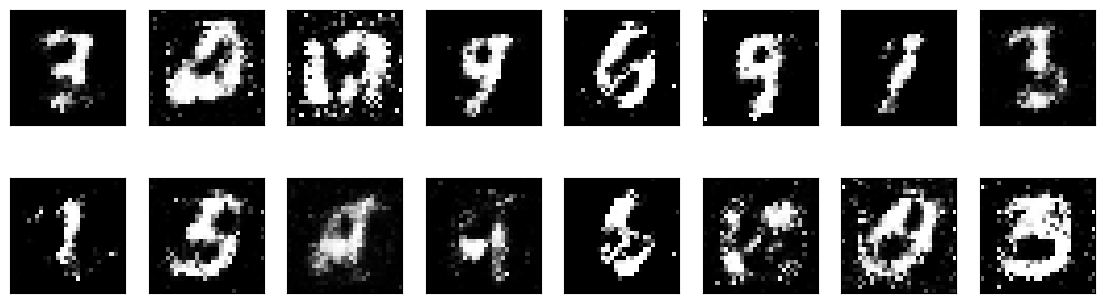

Epoch 6/10:  43%|█████████████████████████████████████████████████████████████████████████▊                                                                                                   | 200/469 [00:16<00:20, 12.92it/s]

2024-03-29 03:15:39 | Epoch [6/10] | Batch 200/469 | d_loss: 1.1106 | g_loss: 1.5038


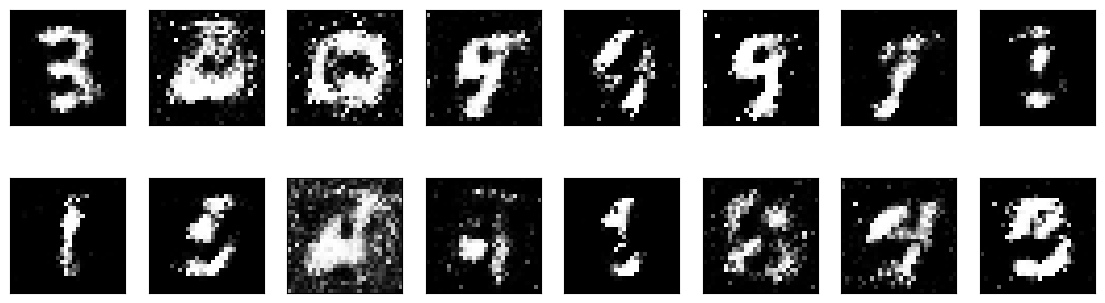

Epoch 6/10:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 300/469 [00:25<00:12, 13.82it/s]

2024-03-29 03:15:47 | Epoch [6/10] | Batch 300/469 | d_loss: 1.1264 | g_loss: 1.2758


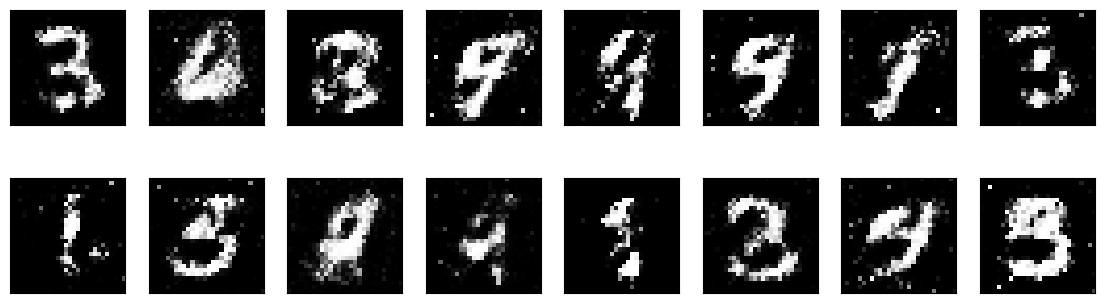

Epoch 6/10:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 400/469 [00:33<00:05, 13.37it/s]

2024-03-29 03:15:55 | Epoch [6/10] | Batch 400/469 | d_loss: 1.2169 | g_loss: 1.2917


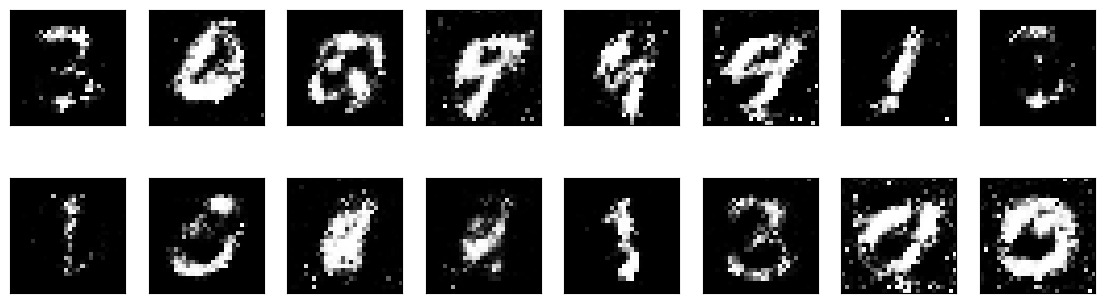

Epoch 7/10:   0%|                                                                                                                                                                                       | 0/469 [00:00<?, ?it/s]

2024-03-29 03:16:01 | Epoch [7/10] | Batch 0/469 | d_loss: 1.2017 | g_loss: 1.1407


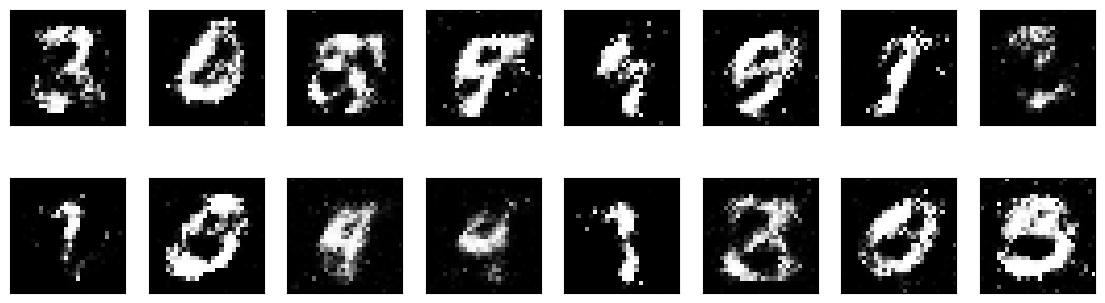

Epoch 7/10:  21%|████████████████████████████████████▋                                                                                                                                         | 99/469 [00:07<00:26, 14.07it/s]

2024-03-29 03:16:09 | Epoch [7/10] | Batch 100/469 | d_loss: 1.1833 | g_loss: 1.2690


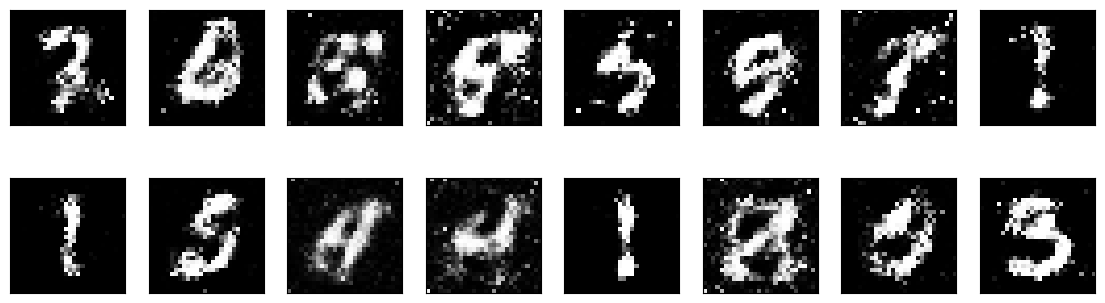

Epoch 7/10:  42%|█████████████████████████████████████████████████████████████████████████▍                                                                                                   | 199/469 [00:16<00:21, 12.78it/s]

2024-03-29 03:16:17 | Epoch [7/10] | Batch 200/469 | d_loss: 1.1741 | g_loss: 1.2267


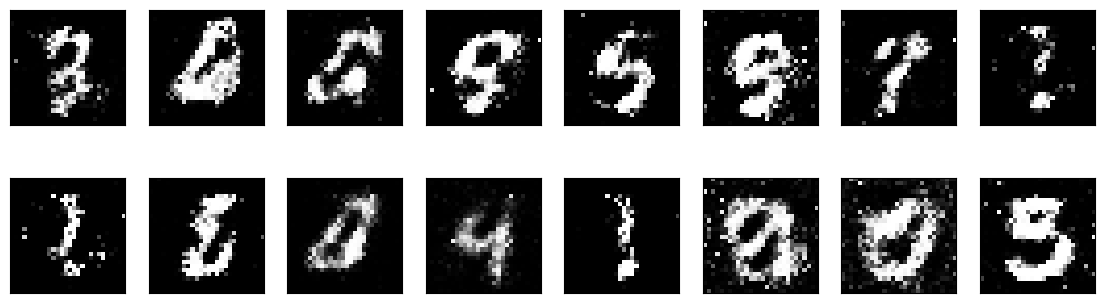

Epoch 7/10:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 299/469 [00:24<00:12, 13.83it/s]

2024-03-29 03:16:25 | Epoch [7/10] | Batch 300/469 | d_loss: 1.0591 | g_loss: 1.5234


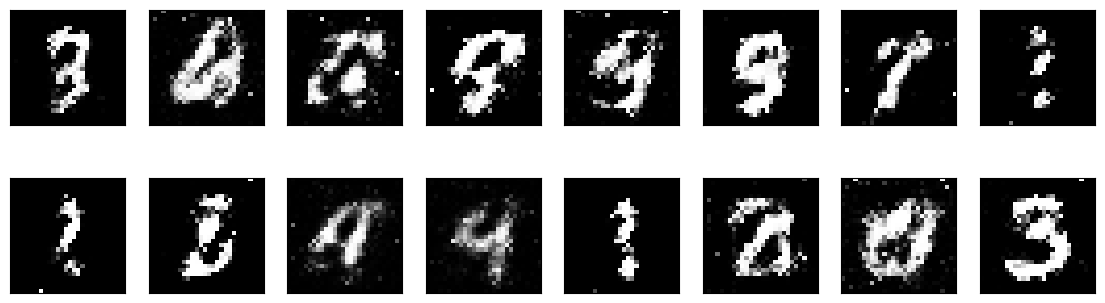

Epoch 7/10:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 399/469 [00:32<00:04, 14.11it/s]

2024-03-29 03:16:33 | Epoch [7/10] | Batch 400/469 | d_loss: 1.3189 | g_loss: 1.1327


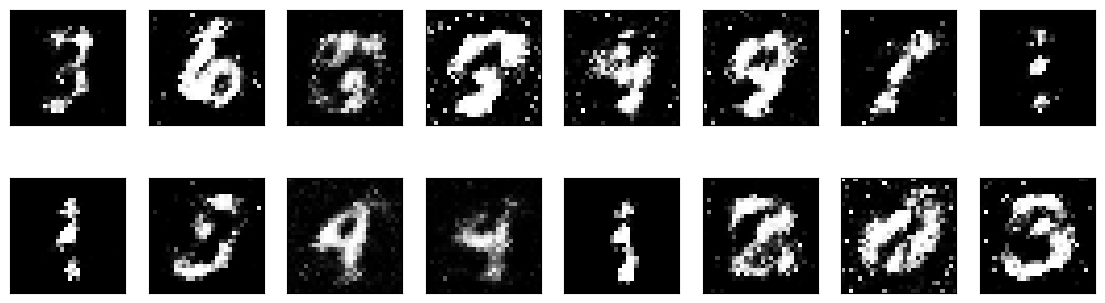

Epoch 8/10:   0%|                                                                                                                                                                                       | 0/469 [00:00<?, ?it/s]

2024-03-29 03:16:39 | Epoch [8/10] | Batch 0/469 | d_loss: 1.0679 | g_loss: 1.3475


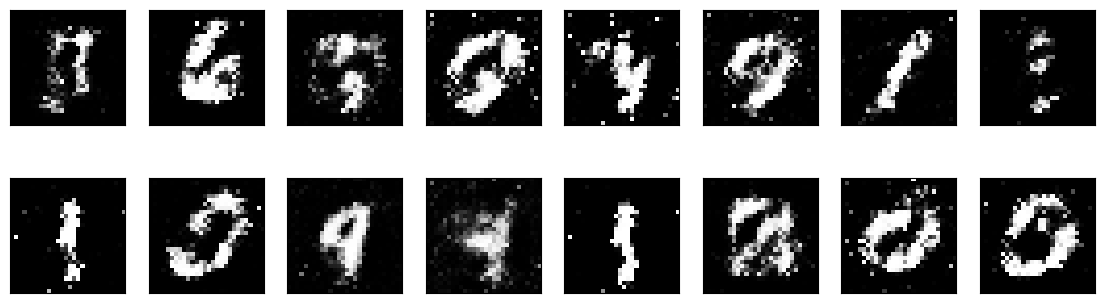

Epoch 8/10:  21%|████████████████████████████████████▋                                                                                                                                         | 99/469 [00:08<00:27, 13.52it/s]

2024-03-29 03:16:48 | Epoch [8/10] | Batch 100/469 | d_loss: 1.0603 | g_loss: 1.4756


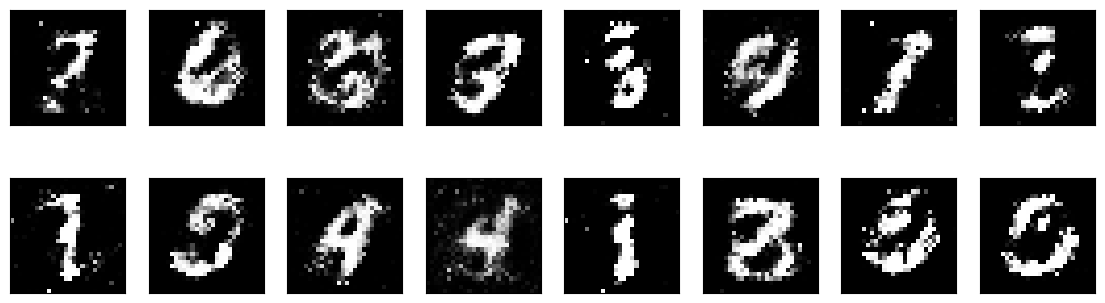

Epoch 8/10:  42%|█████████████████████████████████████████████████████████████████████████▍                                                                                                   | 199/469 [00:16<00:19, 14.14it/s]

2024-03-29 03:16:55 | Epoch [8/10] | Batch 200/469 | d_loss: 1.0606 | g_loss: 1.5585


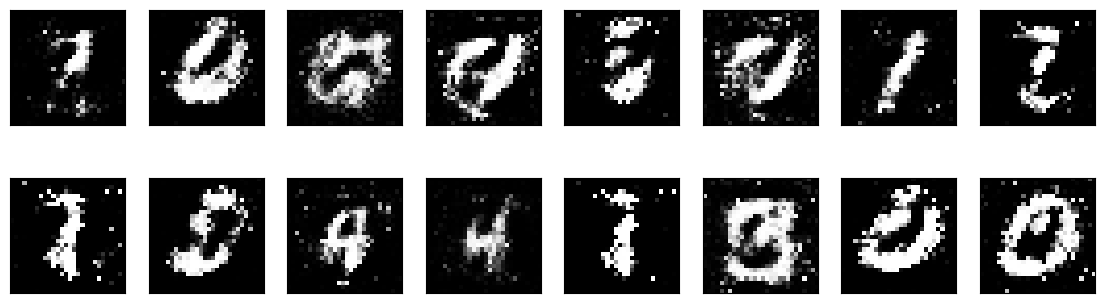

Epoch 8/10:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 299/469 [00:25<00:15, 11.05it/s]

2024-03-29 03:17:04 | Epoch [8/10] | Batch 300/469 | d_loss: 1.1077 | g_loss: 1.2809


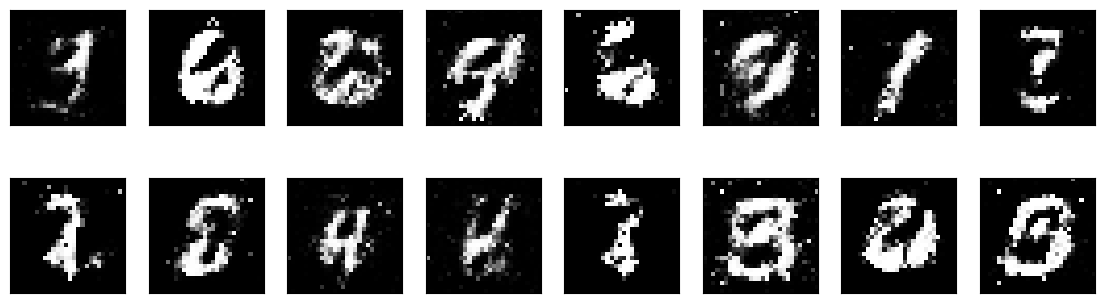

Epoch 8/10:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 400/469 [00:34<00:05, 13.12it/s]

2024-03-29 03:17:14 | Epoch [8/10] | Batch 400/469 | d_loss: 1.2561 | g_loss: 1.0718


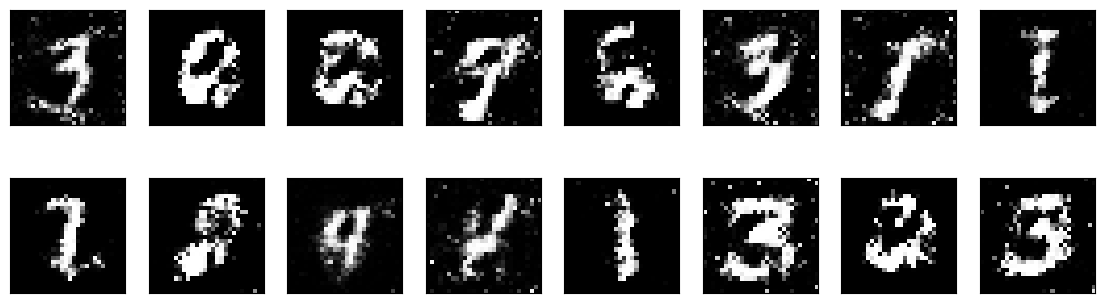

Epoch 9/10:   0%|                                                                                                                                                                                       | 0/469 [00:00<?, ?it/s]

2024-03-29 03:17:20 | Epoch [9/10] | Batch 0/469 | d_loss: 1.0608 | g_loss: 1.5212


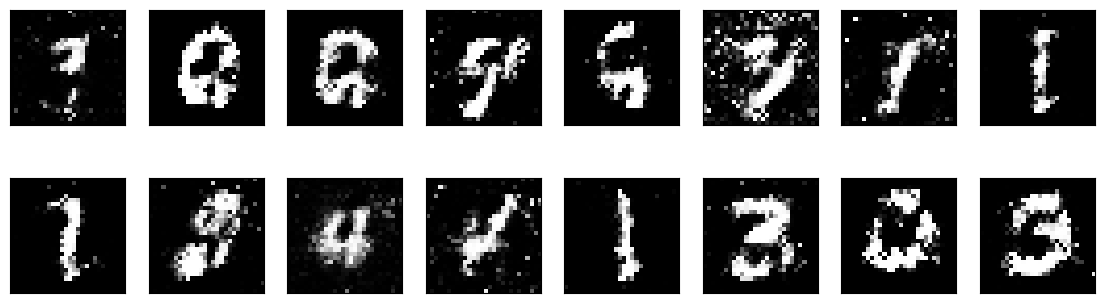

Epoch 9/10:  21%|████████████████████████████████████▋                                                                                                                                         | 99/469 [00:08<00:26, 14.01it/s]

2024-03-29 03:17:28 | Epoch [9/10] | Batch 100/469 | d_loss: 1.1720 | g_loss: 1.3314


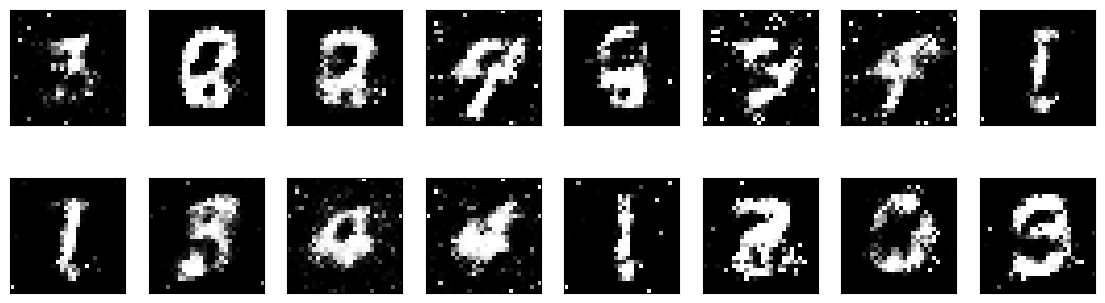

Epoch 9/10:  42%|█████████████████████████████████████████████████████████████████████████▍                                                                                                   | 199/469 [00:16<00:20, 12.96it/s]

2024-03-29 03:17:37 | Epoch [9/10] | Batch 200/469 | d_loss: 1.1002 | g_loss: 1.3080


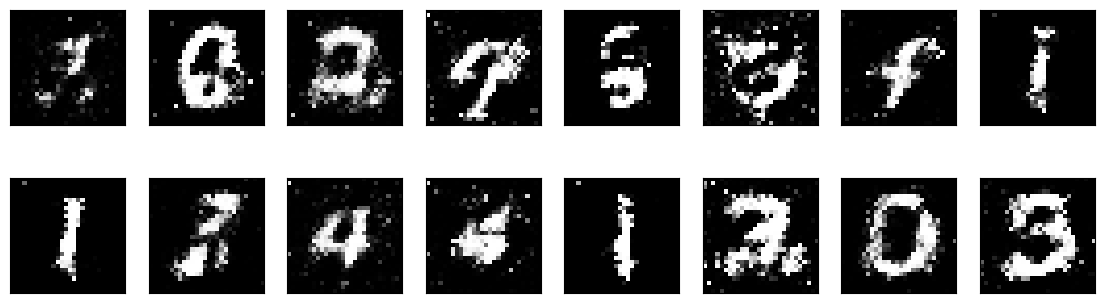

Epoch 9/10:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 299/469 [00:25<00:13, 12.88it/s]

2024-03-29 03:17:45 | Epoch [9/10] | Batch 300/469 | d_loss: 1.2423 | g_loss: 1.3016


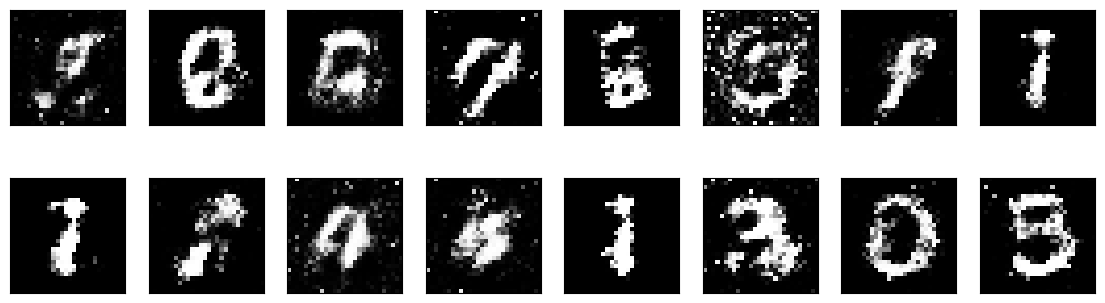

Epoch 9/10:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 399/469 [00:34<00:06, 11.20it/s]

2024-03-29 03:17:54 | Epoch [9/10] | Batch 400/469 | d_loss: 1.1835 | g_loss: 1.1680


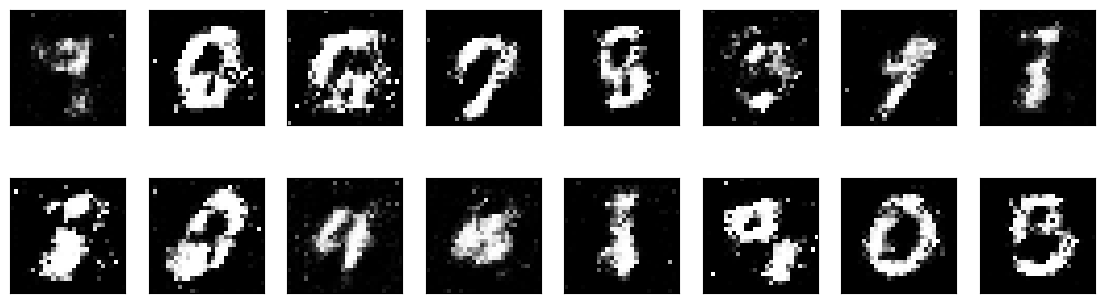

Epoch 10/10:   0%|                                                                                                                                                                                      | 0/469 [00:00<?, ?it/s]

2024-03-29 03:18:00 | Epoch [10/10] | Batch 0/469 | d_loss: 1.1543 | g_loss: 1.0676


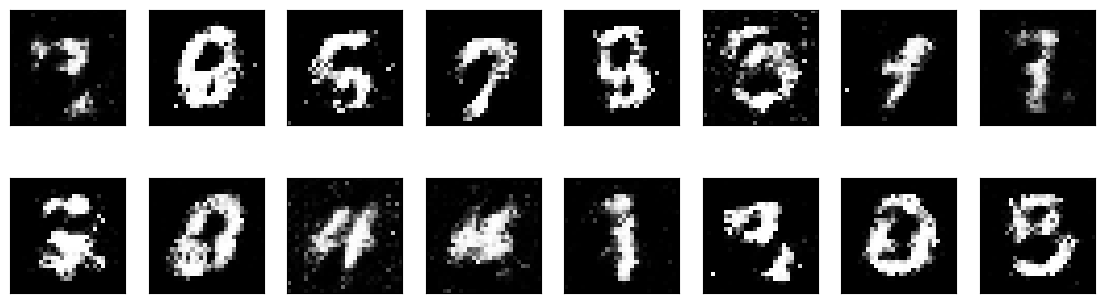

Epoch 10/10:  21%|████████████████████████████████████▌                                                                                                                                        | 99/469 [00:07<00:25, 14.34it/s]

2024-03-29 03:18:08 | Epoch [10/10] | Batch 100/469 | d_loss: 1.2524 | g_loss: 1.0961


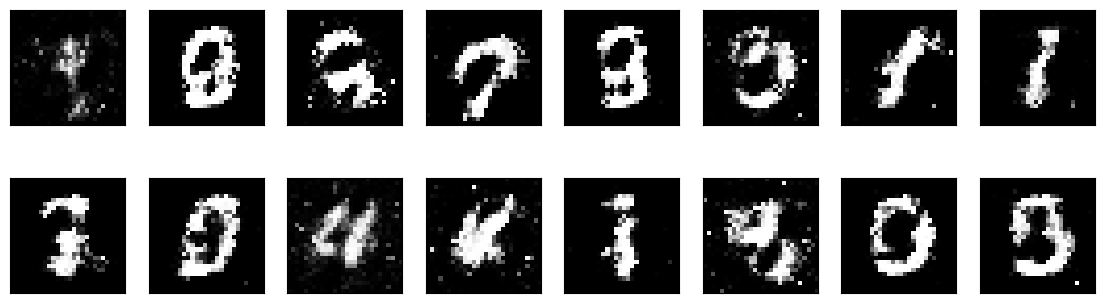

Epoch 10/10:  42%|████████████████████████████████████████████████████████████████████████▉                                                                                                   | 199/469 [00:16<00:19, 13.84it/s]

2024-03-29 03:18:16 | Epoch [10/10] | Batch 200/469 | d_loss: 1.1325 | g_loss: 1.1864


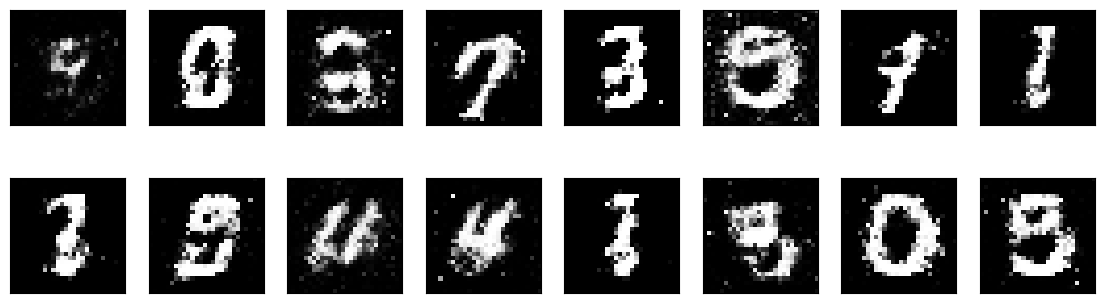

Epoch 10/10:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 299/469 [00:24<00:13, 12.66it/s]

2024-03-29 03:18:25 | Epoch [10/10] | Batch 300/469 | d_loss: 1.1640 | g_loss: 1.2054


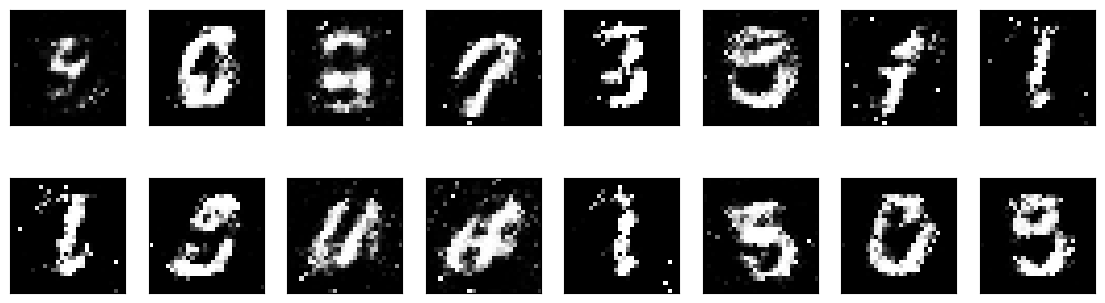

Epoch 10/10:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 399/469 [00:32<00:05, 13.66it/s]

2024-03-29 03:18:33 | Epoch [10/10] | Batch 400/469 | d_loss: 1.1039 | g_loss: 1.2667


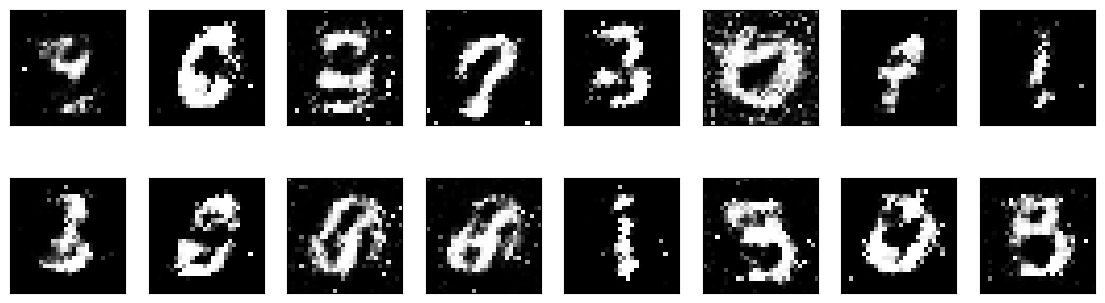

In [154]:
# Training hyperparams & others
num_epochs = 10
print_every = 100
sample_size = 16

# Keep track of loss and generated, "fake" samples
samples = []
# losses = []

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
fixed_z = np.random.uniform(-1, 1, size=(sample_size, latent_dim)) # size (16, 128)
fixed_z = torch.from_numpy(fixed_z).float()

# Train the network
D.train()
G.train()
for epoch in range(num_epochs):
    # Use tqdm for progress tracking
    data_loader = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
    for batch_i, (real_images, _) in enumerate(data_loader):

        batch_size = real_images.size(0) # torch.Size([128, 1, 28, 28])
        real_images = real_images * 2 - 1 # Rescale from [0, 1] to [-1, 1]

        # ====================================
        #       TRAIN THE DISCRIMINATOR
        # ====================================

        d_optimizer.zero_grad()
        
        # Steps 1,2 Train with real images (Feed forward), calculate loss for real 
        # Compute the discriminator losses on real images
        # smooth the labels
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)
        
        # Train with fake images (Feed forward)
        # Generate fake images
        # Gradients don't have to flow during this step
        with torch.no_grad():
            z = np.random.uniform(-1, 1, size=(batch_size, latent_dim))
            z = torch.from_numpy(z).float()
            fake_images = G(z)

        # Compute the discriminator losses on fake images
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # Add up the loss and perform backpropagation
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()

        # ====================================
        #       TRAIN THE GENERATOR
        # ====================================
        g_optimizer.zero_grad()
        # Train with fake images and flipped labels

        # Generate fake images (Forward pass)
        z = np.random.uniform(-1, 1, size=(batch_size, latent_dim))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images
        D_fake = D(fake_images) # D: real 1 fake 0 G: real 0 fake 1
        g_loss = real_loss(D_fake) # use real loss to flip labels

        # Perform backpropagation
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            time = str(datetime.now()).split('.')[0]
            print(f'{time} | Epoch [{epoch+1}/{num_epochs}] | Batch {batch_i}/{len(train_loader)} | d_loss: {d_loss.item():6.4f} | g_loss: {g_loss.item():6.4f}')

        # Generate and save sample, fake images
        if batch_i % print_every == 0:
            G.eval()  # Set generator to evaluation mode
            with torch.no_grad():
                samples_z = G(fixed_z)
                samples.append(samples_z)
                view_samples(-1, samples)
            G.train()  # Back to training mode
        
# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)   